# Application of machine learning approach in image classification problem

![ml_workflow](img_embed/w9_ml_flow.webp)

1. Method 1: Color histogram features + SVM
2. Method 2: BOVW + random forest 

# Step 0: Setup

In [1]:
import cv2 as cv
import numpy as np
import os

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

In [2]:
import matplotlib.pyplot as plt

# Visualization of images
Rename the images directory to "is_that_santa" 
## Santa from training directory

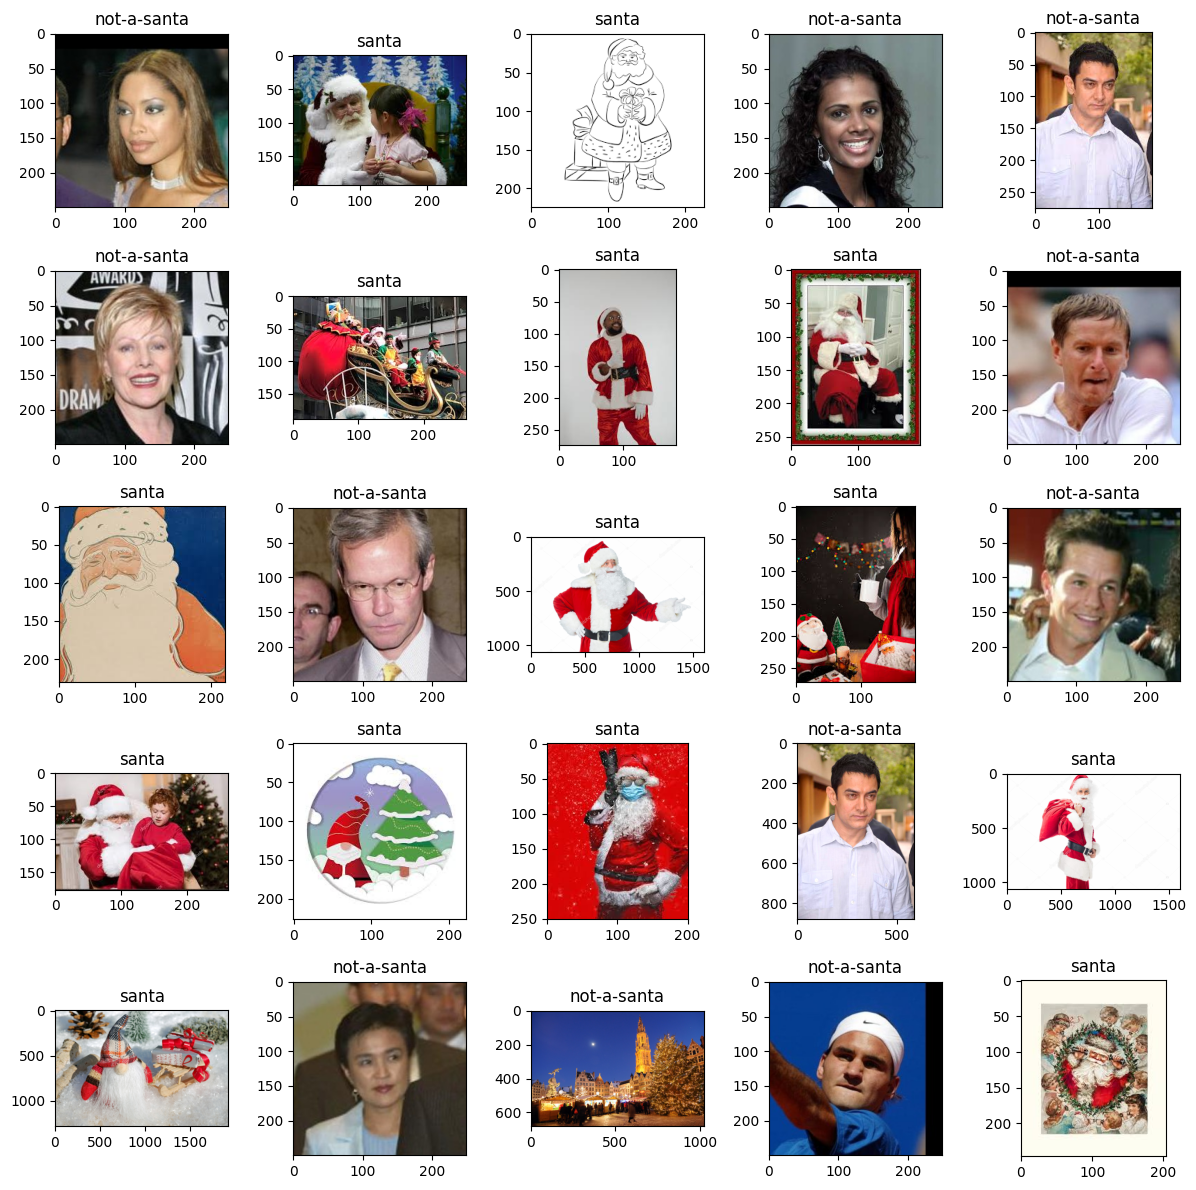

In [3]:
from pathlib import Path
import random 

img_dir = Path() / "images" / "w9" / "is_that_santa" / "train"
santa_img_filenames = list(img_dir.glob("*/*.jpg"))
selected_img_filenames = random.choices(santa_img_filenames, k=25)

plt.figure(figsize=(12, 12))
for i, filename in enumerate(selected_img_filenames):
    plt.subplot(5, 5, i+1)
    img = cv.imread(cv.samples.findFile(str(filename)))
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    fn = str(filename)
    # Windows OS filename
    title = fn.split("\\")[-2]
    plt.title(title)

plt.tight_layout()
plt.show()

# Data preprocessing and feature extraction
1. Preprocessing: Gaussian filter for denoising purpose
2. Feature extraction: Color histogram
3. Dimensionality reduction: Principal component analysis (PCA)

In [4]:
img = cv.imread("images/w9/is_that_santa/train/santa/10.Santa.jpg")
img = cv.GaussianBlur(img, (5, 5), 0)
channels = cv.split(img)
h, w = img.shape[:2]
features = []
hist_all = []

for channel in channels:
    hist = cv.calcHist([channel], [0], None, [256], [0, 256])
    hist /= (h * w)
    hist_all.extend(hist.flatten())

len(hist_all)

768

In [4]:
def color_hist_feature_extract(filename, denoise=True):
    """"""
    img = cv.imread(cv.samples.findFile(filename))
    if denoise:
        img = cv.GaussianBlur(img, (5, 5), 0)
    channels = cv.split(img)
    h, w = img.shape[:2]
    hist_all = []
    for channel in channels:
        hist = cv.calcHist([channel], [0], None, [256], [0, 256])
        hist /= (h * w)
        hist_all.extend(hist.flatten())

    return hist_all

In [24]:
list(img_dir.glob("*"))

[WindowsPath('images/w9/is_that_santa/train/not-a-santa'),
 WindowsPath('images/w9/is_that_santa/train/santa')]

In [25]:
for class_name in img_dir.glob("*/*.jpg"):
    print(class_name.parents[0])
    filename = str(cla)
    break

images\w9\is_that_santa\train\not-a-santa


## Loop through all the training images and extract color features

In [5]:
X_train = []
y_train = []

for fn in santa_img_filenames:
    filename = str(fn)
    color_hist = color_hist_feature_extract(filename)
    label = filename.split("\\")[-2]
    X_train.append(color_hist)
    y_train.append(label)

In [6]:
print("Number of training features: ", len(X_train))
print("Number of training labels: ", len(y_train))

Number of training features:  614
Number of training labels:  614


In [26]:
test_img_dir = Path() / "images" / "w9" / "is_that_santa" / "test"
test_img_filenames = list(test_img_dir.glob("*/*.jpg"))

X_test = []
y_test = []

for fn in test_img_filenames:
    filename = str(fn)
    color_hist = color_hist_feature_extract(filename)
    label = filename.split("\\")[-2]
    X_test.append(color_hist)
    y_test.append(label)

X_test = np.array(X_test)

In [28]:
print("Number of test features: ", len(X_test))
print("Number of test labels: ", len(y_test))

Number of test features:  616
Number of test labels:  616


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encode = le.fit_transform(y_train)
y_train_encode[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
le.classes_

array(['not-a-santa', 'santa'], dtype='<U11')

In [9]:
X_train = np.array(X_train)
X_train.shape

(614, 768)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

pca = PCA(random_state=99)
X_train_pca = pca.fit_transform(X_train_standardized)

In [11]:
idx_select = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.9) + 1

In [12]:
X_train_pca_final = X_train_pca[:, :idx_select]
X_train_pca_final.shape

(614, 74)

# RBF SVM

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=idx_select, random_state=99),
    SVC(kernel='rbf', random_state=99)
)

In [22]:
param_distrib = {
    "svc__gamma": loguniform(0.0001, 0.1),
    "svc__C": uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5, random_state=100)

In [23]:
rnd_search_cv.fit(X_train, y_train_encode)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca',
                                              PCA(n_components=74,
                                                  random_state=99)),
                                             ('svc', SVC(random_state=99))]),
                   n_iter=100,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002939A2D03E0>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002939A340E30>},
                   random_state=100)

In [25]:
best_model = rnd_search_cv.best_estimator_

In [29]:
# perform the label encoding for y_test
y_test_encode = le.transform(y_test)

In [30]:
best_model.score(X_test, y_test_encode)

0.7548701298701299

## Confusion matrix

In [31]:
le.classes_

array(['not-a-santa', 'santa'], dtype='<U11')

In [32]:
le.inverse_transform([0])

array(['not-a-santa'], dtype='<U11')

In [33]:
from sklearn.metrics import confusion_matrix

test_pred = best_model.predict(X_test)
confusion_matrix(le.inverse_transform(y_test_encode), le.inverse_transform(test_pred))

array([[261,  47],
       [104, 204]], dtype=int64)

# BOVW + random forest classifier

## Setup

In [1]:
import cv2 as cv
import numpy as np
from pathlib import Path

## Extract feature descriptors on all the training images
There are some feature descriptors to choose from. In this project, ORB feature descriptors is chosen.

In [2]:
# set a maximum number of feature descriptors extracted from each image
orb = cv.ORB_create(nfeatures=300)
# define paths
base_dir = Path() / "images" / "w9" / "is_that_santa" 
train_data_dir = base_dir / "train"

# features descriptors per image array
descriptors_per_img = []
y_train = []

for filename in train_data_dir.glob("*/*.jpg"):
    gray = cv.imread(str(filename), cv.IMREAD_GRAYSCALE)
    if gray is not None:
        _, descriptors = orb.detectAndCompute(gray, None)
        descriptors_per_img.append(descriptors)
        # the folder name is the training label, y
        y_train.append(filename.parent.parts[-1])

In [3]:
descriptors_all = np.vstack(descriptors_per_img)
descriptors_all.shape

(164215, 32)

In [4]:
print("the number of training images: ", len(descriptors_per_img))
print("the number of training labels: ", len(y_train))

the number of training images:  614
the number of training labels:  614


## Create vocabulary (k-means clustering)

### Choose the best k with silhoutte score

In [5]:
from sklearn.cluster import MiniBatchKMeans

k_list = [100, 125, 150, 175, 200, 225, 250, 275, 300]
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=9).fit(descriptors_all)
               for k in k_list]

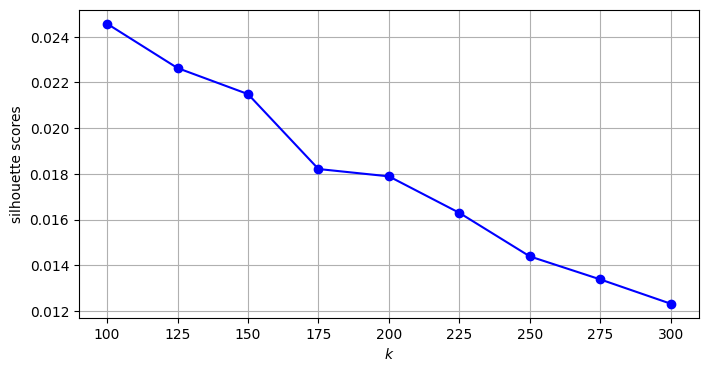

In [6]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
idx = rng.integers(0, high=descriptors_all.shape[0], size=(5_000,))

silhouette_scores = [silhouette_score(descriptors_all[idx], model.labels_[idx])
                    for model in kmeans_per_k]

plt.figure(figsize=(8, 4))
plt.plot(k_list, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("silhouette scores")
plt.grid()
plt.show()

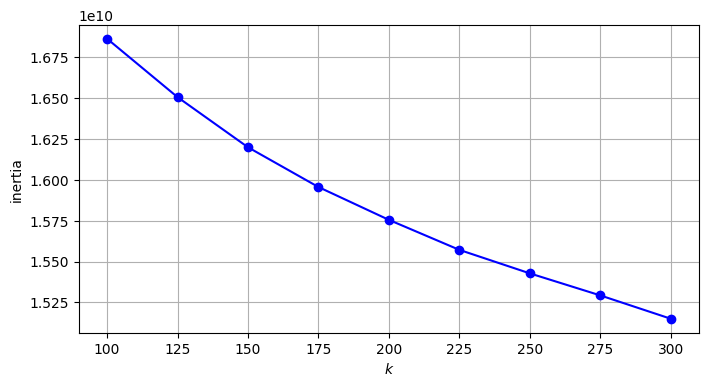

In [40]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 4))
plt.plot(k_list, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("inertia")
plt.grid()
plt.show()

### Retrieve the best k-means clustering model and conduct vector quantization

In [7]:
k_best = k_list[np.argmax(silhouette_scores)]
kmeans_opt = kmeans_per_k[np.argmax(silhouette_scores)]
X_train = []

for descriptor in descriptors_per_img:
    # get the k-means prediction for all the descriptors per image
    pred = kmeans_opt.predict(descriptor)
    hist = np.bincount(pred, minlength=k_best)
    X_train.append(hist)

# TF-IDF

In [8]:
N = len(X_train)

X_train = np.array(X_train)
df = np.sum(X_train > 0, axis=0)
idf = np.log(N / df)

X_train_tfidf = X_train * idf
X_train_tfidf.shape

(614, 100)

In [43]:
idf

array([0.26939216, 0.2503842 , 0.17195205, 0.20139481, 0.20939485,
       0.26301594, 0.23791002, 0.1490065 , 0.12842579, 0.14523291,
       0.28659689, 0.24412766, 0.17971908, 0.20738883, 0.34006173,
       0.16809104, 0.55069802, 0.17195205, 0.16041346, 0.21948575,
       0.17388816, 0.2114049 , 0.12288561, 0.25457707, 0.18362534,
       0.13959909, 0.30189773, 0.18754691, 0.20738883, 0.13959909,
       0.18754691, 0.11737595, 0.12657565, 0.25457707, 0.2235508 ,
       0.31743633, 0.13586077, 0.22151621, 0.19741866, 0.16616612,
       0.27366567, 0.13399683, 0.43605865, 0.1414735 , 0.20738883,
       0.17971908, 0.1816703 , 0.1490065 , 0.26726223, 0.11554613,
       0.29969751, 0.25878761, 0.24205081, 0.15659667, 0.17971908,
       0.15850324, 0.20338883, 0.20139481, 0.09027402, 0.26726223,
       0.26726223, 0.17001969, 0.31967598, 0.3492572 , 0.15469372,
       0.15089864, 0.3152017 , 0.26089954, 0.2114049 , 0.26513683,
       0.21948575, 0.20139481, 0.23997827, 0.14711792, 0.10826

In [9]:
idf.shape

(100,)

# Train random forest classifier

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=300, random_state=10,
                               n_jobs=-1)

label_encoder = LabelEncoder()
y_train_encode = label_encoder.fit_transform(y_train)

# Train random forest classifier
rf_clf.fit(X_train_tfidf, y_train_encode)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=10)

# Preprocess the test data
1. Load the image in grayscale format
2. Apply ORB descriptors
3. vector quantization
4. tfidf
5. Model evaluation

In [11]:
orb = cv.ORB_create(nfeatures=300)

test_data_dir = base_dir / "test"
X_test = []
y_test = []

for filename in test_data_dir.glob("*/*.jpg"):
    gray = cv.imread(str(filename), cv.IMREAD_GRAYSCALE)
    if gray is not None:
        _, descriptors = orb.detectAndCompute(gray, None)
        if descriptors is None:
            continue
        # vector quantization
        pred = kmeans_opt.predict(descriptors)
        hist = np.bincount(pred, minlength=k_best)
        hist_idf = hist * idf
        X_test.append(hist_idf)
        # the folder name is the training label, y
        y_test.append(filename.parent.parts[-1])

In [12]:
X_test = np.array(X_test)
y_test_encode = label_encoder.transform(y_test)
X_test.shape

(615, 100)

In [27]:
label_encoder.classes_

array(['not-a-santa', 'santa'], dtype='<U11')

In [28]:
label_encoder.inverse_transform([0, 1])

array(['not-a-santa', 'santa'], dtype='<U11')

# Evaluation

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

test_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test_encode, test_pred)
print("Accuracy score: ", round(acc*100, 2), " %")

Accuracy score:  77.24  %


In [14]:
confusion_matrix(y_test_encode, test_pred)

array([[238,  70],
       [ 70, 237]], dtype=int64)

# Save the kmeans clustering model, IDF matrix and random forest model
1. The maximum number of ORB keypoint descriptors is set to 300.
2. The best k for k-means clustering = 100
3. The prediction encoding:
```
{"0": "not-a-santa", "1": "santa"}
```

In [15]:
# save the IDF matrix
with open("ml_model_archive/idf.npy", "wb") as f:
    np.save(f, idf)

In [17]:
# save the k-means clustering and random forest model
from pickle import dump
with open("ml_model_archive/kmeans_orb.pickle", "wb") as f:
    dump(kmeans_opt, f, protocol=5)

In [18]:
with open("ml_model_archive/random_forest_clf_BOVW.pickle", "wb") as f:
    dump(rf_clf, f, protocol=5)

# Prediction using new images 

In [19]:
from utils import download_save_img

In [20]:
filename = "ml_model_archive/santa_test.jpg"
url = "https://img.freepik.com/free-photo/santa-claus-red-costume-isolated-white_155003-20460.jpg?t=st=1723252405~exp=1723256005~hmac=af8429e437b0146982641e6877a83f49e3b25d805d7e94b9947201700299c3ae&w=900"
download_save_img(url, filename)

## Load the IDF, k-means clustering and random forest classifier

In [21]:
with open("ml_model_archive/idf.npy", "rb") as f:
    idf = np.load(f)

In [25]:
from pickle import load
with open("ml_model_archive/kmeans_orb.pickle", "rb") as f:
    kmeans_opt = load(f)

with open("ml_model_archive/random_forest_clf_BOVW.pickle", "rb") as f:
    rf_clf = load(f)

In [36]:
k_best = 100
max_orb_features = 300

orb = cv.ORB_create(nfeatures=max_orb_features)

img_test = cv.imread("ml_model_archive/santa_test.jpg", cv.IMREAD_GRAYSCALE)
_, descriptors = orb.detectAndCompute(img_test, None)
pred = kmeans_opt.predict(descriptors)
hist = np.bincount(pred, minlength=k_best)
hist_idf = hist * idf
pred = rf_clf.predict(hist_idf[np.newaxis, :])
print(label_encoder.inverse_transform(pred))

# if pred[0] == 1:
#     prediction = "santa"
# else:
#     prediction = "not-a-santa"
# print(prediction)

['santa']


In [38]:
%run santa_or_not_classifier.py --imagePath ml_model_archive/santa_test.jpg

santa
